<a href="https://colab.research.google.com/github/laurabishop/EyeTrackingDemo/blob/main/DSD_ScienceOfGaze_PupilFiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Science of Gaze: Mapping Attention and Interaction Through Eye-Tracking**
## Demonstration of pupil and gaze processing procedures


---



## 1. Setup

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 6)
install.packages("FBN")
install.packages("mgsub")
install.packages("sciplot")
lapply(c("ggplot2", "mgsub", "FBN", "sciplot"), require, character.only = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: ggplot2

Loading required package: mgsub

Loading required package: FBN

Loading required package: sciplot



[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

## 2. Pre-processing of pupil data

Pupil data normally contain blinks and other artifacts that should be removed before the data are used analysed.
* Complete blinks occur when the eyelids fully cover the pupil. These might appear cause gaps in the data (missing values) or values of pupil size 0.
* Partial blinks occur when the pupil is only partially covered by the eyelid. This results in a pupil size that is greater than 0, but much smaller than the average size for the trial.

Below is an example of data containing complete and partial blinks.


In [ ]:
eyetracking <- read.table("P2067560969.txt")
session.no <- 1
track <- "3c879SgICdtgNLUdzHHs8F"
tdata <- eyetracking[eyetracking$session == session.no & eyetracking$spotify_id == track, ]

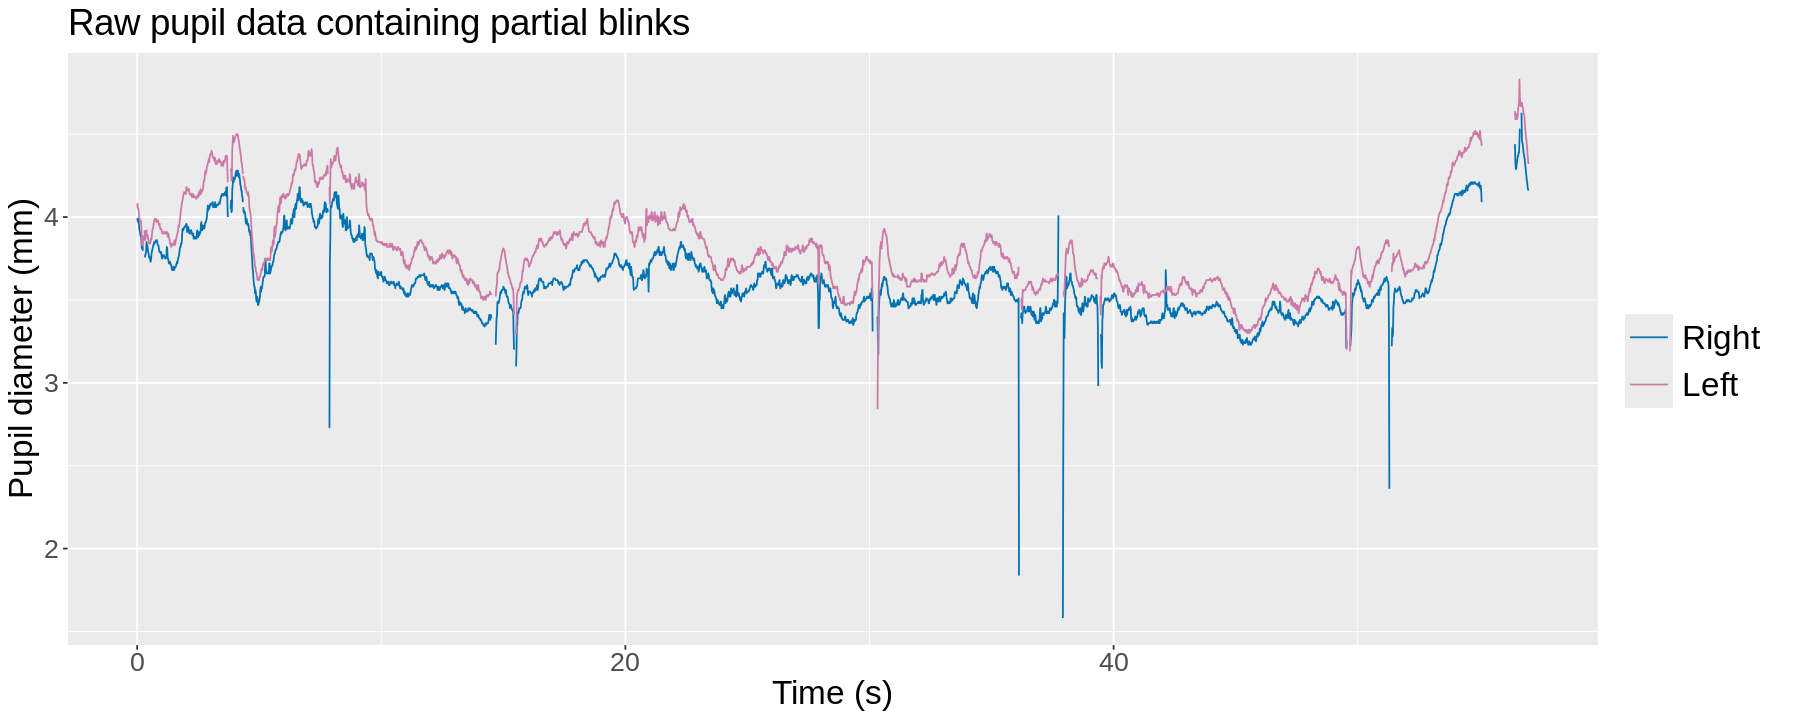

In [ ]:
raw.plot <- ggplot(tdata, aes(x = tracktime)) + #xlim(30,40) +
                geom_line(aes(y = Pupil.diameter.right..mm., colour = "Right")) +
                geom_line(aes(y = Pupil.diameter.left..mm., colour = "Left")) +
                scale_colour_manual("", breaks = c("Right", "Left", "Smoothed", "Interpolated"),
                                    values = c("#0072B2", "#CC79A7", "#E69F00")) +
                ggtitle("Raw pupil data containing partial blinks") +
                xlab("Time (s)") + ylab("Pupil diameter (mm)") +
                theme(plot.title = element_text(size = 22),
                      axis.text = element_text(size = 16), axis.title = element_text(size = 20),
                      legend.text = element_text(size = 20), legend.key.size = unit(1, "cm"))
raw.plot

Pupil data must be processed to remove complete and partial blinks. This can be done in two ways:
* Some eye-tracking software includes a function for distinguishing fixations, saccades, and blinks. To get "clean" data, you can extract only the fixations. These will not be evenly spaced in time, which might affect your subsequent analyses.
* If no blink detection function is available, data can be filtered. Most pupil filters identify blinks using information about extreme pupil values and rates of change.

Below, we demonstrate a procedure for filtering pupil data. This filter is customizable so that it works with data collected under different conditions using different eye-tracking devices. Depending on the quality of the data and the aim of the analyses, some steps might be skipped (e.g., smoothing). It might also be necessary to change some of the parameters. In this demo, we run steps 2-6, and the filter outputs a single continuous (i.e., without gaps) vector of smoothed pupil data.

* **Step 1**: *We skip this step here because the data do not contain values of 0.* Some data contain pupil sizes of 0, which arise during complete blinks or in moments where the pupil cannot be detected, for example, because the participant looks away from the eyetracker. Some software might code these values as NA (missing data) instead of 0. If values of 0 are present in the data, the first step would be to exclude them and replace them with NAs.
* **Step 2**: Filter out extreme velocities for each pupil individually. This targets the "edges" of blinks and other sudden changes in pupil size that arise because of mis-tracking.
* **Step 3**: Average left and right pupils.
* **Step 4**: Filter out extreme low values. Mostly these are samples from partial blinks that have excaped the velocity filter.
* **Step 5**: Run a linear interpolation to fill gaps. You can use other types of interpolations here. For example, a spline interpolation might be prefered in some cases (depending on how the data look, what size of gaps you need to fill, and what your eventual analysis will be). Here, we have some large gaps in some trials and prefer to maintain the average (tonic) pupil size in those cases.
* **Step 6**: Run a median filter to smooth the data.

In [ ]:
outlier.value <- 3 # Used for defining outlier velocities in pupil filtering
low.threshold <- 2 # Used for cutting off values that are too far below trial mean
window.size <- 17 # Used to set the smoothing window

In [ ]:
# Filter out extreme velocities for left pupil
tdata$xmm_velLeft <- with(tdata, c(NA, diff(Pupil.diameter.left..mm.))/c(NA, diff(timestamp)))
out.boundLeft <- outlier.value * sd(tdata$xmm_velLeft, na.rm = T)
tdata$xmm_ppLeft <- with(tdata, ifelse(abs(xmm_velLeft) > out.boundLeft, NA, Pupil.diameter.left..mm.))

# Filter out extreme velocities for right pupil
tdata$xmm_velRight <- with(tdata, c(NA, diff(Pupil.diameter.right..mm.))/c(NA, diff(timestamp)))
out.boundRight <- outlier.value * sd(tdata$xmm_velRight, na.rm = T)
tdata$xmm_ppRight <- with(tdata, ifelse(abs(xmm_velRight) > out.boundRight, NA, Pupil.diameter.right..mm.))

# Average filtered left and right pupils, then filter out extreme low values
tdata$pupil_lr <- with(tdata, (xmm_ppLeft + xmm_ppRight)/2)
low.bound <- mean(tdata$pupil_lr, na.rm = T) - low.threshold * sd(tdata$pupil_lr, na.rm = T)
tdata$xmm_ppp <- with(tdata, ifelse(pupil_lr < low.bound, NA, pupil_lr))

# Interpolate to fill gaps
tdata$pupil <- with(tdata, approx(timestamp, xmm_ppp, xout = timestamp)$y)

# Smoothing
tdata$smooth.pupil <- medianFilter(tdata$pupil, windowSize = window.size)

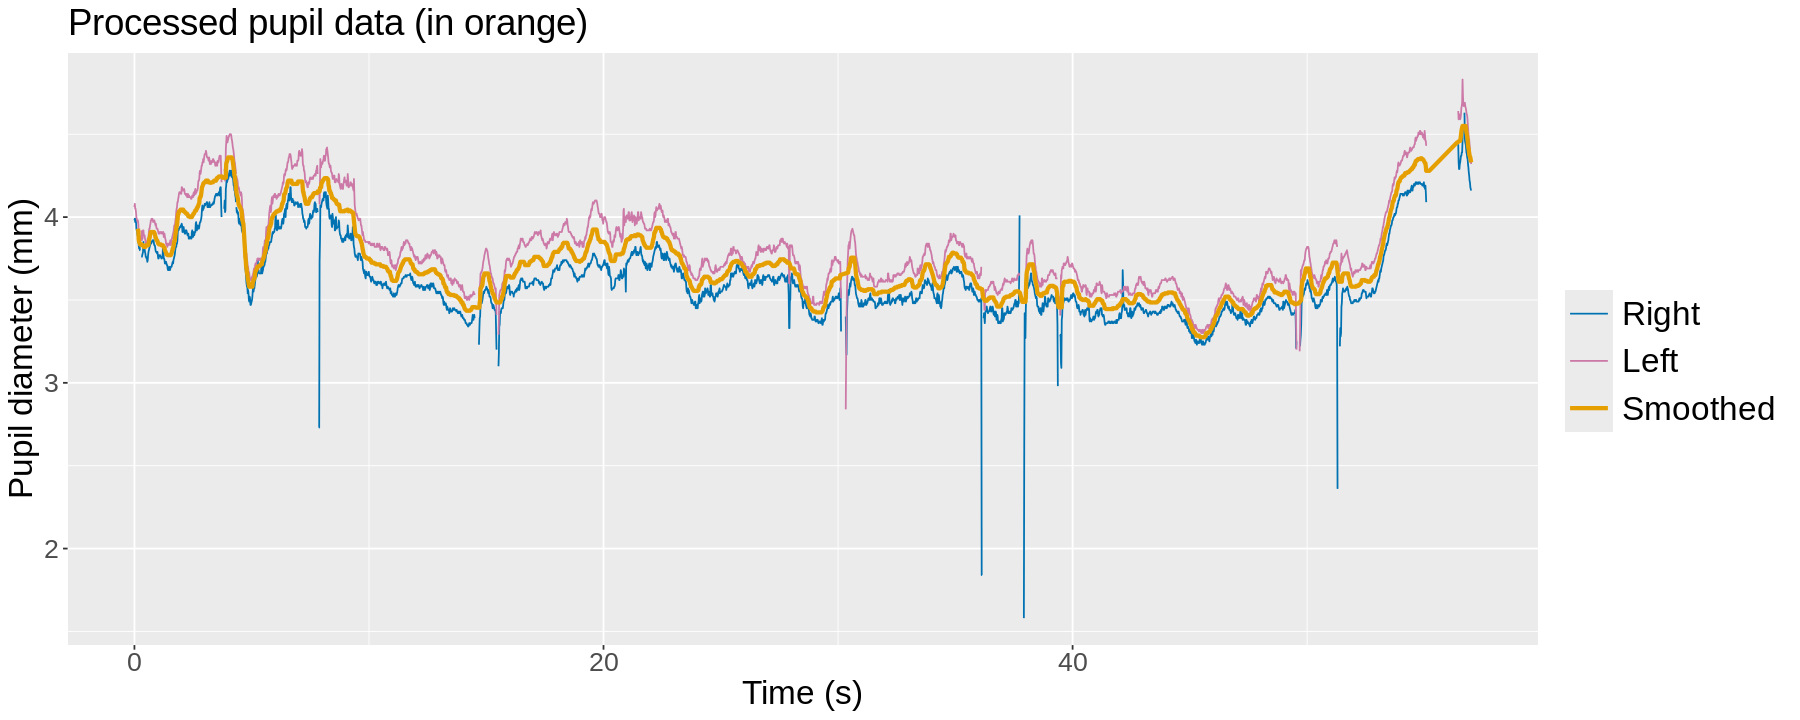

In [ ]:
processed.plot <- raw.plot + geom_line(data = tdata, aes(y = smooth.pupil, colour = "Smoothed"), size = 1.2) +
  ggtitle("Processed pupil data (in orange)")
suppressWarnings(print(processed.plot))